<a href="https://colab.research.google.com/github/priyadharshini13/oxford_ml_project/blob/main/SupplyChainCapstone_GPTNeoforCausalLLM_UserStory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmptzhdehc8/kxueodsn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptzhdehc8/euvadjyl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66196', 'data', 'file=/tmp/tmptzhdehc8/kxueodsn.json', 'init=/tmp/tmptzhdehc8/euvadjyl.json', 'output', 'file=/tmp/tmptzhdehc8/prophet_modelaryi84fd/prophet_model-20240515210607.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:06:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:06:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


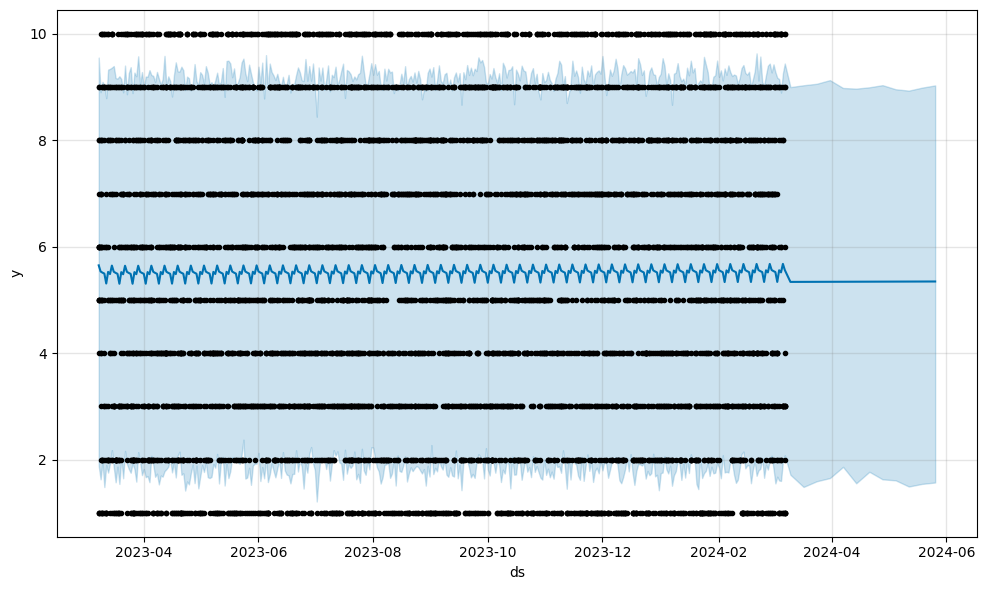

tokenizer_config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/10.7G [00:00<?, ?B/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [ ]:
import pandas as pd
from prophet import Prophet
import numpy as np
import matplotlib.pyplot as plt
from transformers import GPTNeoForCausalLM, GPT2Tokenizer
import torch

# Load the dataset
file_path = '/content/Supply chain capstone.csv'
data = pd.read_csv(file_path)

# Convert 'Date of Sale' to datetime format
data['Date of Sale'] = pd.to_datetime(data['Date of Sale'])

# Extract additional time-based features
data['Month'] = data['Date of Sale'].dt.month
data['Year'] = data['Date of Sale'].dt.year
data['Quarter'] = data['Date of Sale'].dt.quarter

# Prepare the data for Prophet
df = data[['Date of Sale', 'Units Sold']].rename(columns={'Date of Sale': 'ds', 'Units Sold': 'y'})

# Initialize and fit the model
model = Prophet()
model.fit(df)

# Make a future dataframe for 12 weeks
future = model.make_future_dataframe(periods=12, freq='W')
forecast = model.predict(future)

# Display the forecast
model.plot(forecast)
plt.show()

# Example inventory and lead time data
data['Current Inventory'] = np.random.randint(100, 500, size=len(data))
data['Lead Time (weeks)'] = np.random.randint(1, 4, size=len(data))

# Calculate optimal order quantity
def calculate_order_quantity(current_inventory, forecasted_sales, lead_time):
    return max(0, forecasted_sales - current_inventory + lead_time * (forecasted_sales / 4))

# Apply the function to forecasted sales
forecasted_sales = forecast['yhat'][-12:]  # Last 12 weeks forecast
data['Optimal Order Quantity'] = data.apply(lambda row: calculate_order_quantity(row['Current Inventory'], forecasted_sales.mean(), row['Lead Time (weeks)']), axis=1)

# Load the GPT-Neo model and tokenizer
model_name = "EleutherAI/gpt-neo-2.7B"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPTNeoForCausalLM.from_pretrained(model_name)

# Define the message
message = """
As an inventory manager, the following adjustments have been made based on the latest sales forecast and supplier lead times:
"""

# Add adjustments exceeding predefined thresholds to the message
threshold = 100
adjustments = data[data['Optimal Order Quantity'] > threshold]
for index, row in adjustments.iterrows():
    message += f"\n- Product: {row['Product']}, Adjusted Order Quantity: {row['Optimal Order Quantity']}"

# Tokenize and generate the response
inputs = tokenizer(message, return_tensors="pt")
outputs = model.generate(inputs["input_ids"], max_length=500)

# Decode and print the generated text
notification = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(notification)


In [3]:
!pip install prophet